In [1]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import time
import momepy

import os
import sys

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import src

/home/edgaregurrola/.cache/pypoetry/virtualenvs/vref-walkability-index-7rDk_fsn-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

In [2]:
blocks = gpd.read_file('../data/processed/medellin_blocks.shp')
print(blocks.shape)
blocks.head(2)

(20203, 22)


,MANZ_CCNCT,pop,n_res,n_ind,n_com,n_ser,n_hom,n_muj,n_00_09_y,n_10_19_y,...,n_40_49_y,n_50_59_y,n_60_69_y,n_70_79_y,n_80_mo_y,n_edu_pri,n_edu_sec,n_edu_sup,n_edu_pos,geometry
0,0508810000000011010101,90.0,89.0,0.0,1.0,0.0,124.0,140.0,32.0,42.0,...,27.0,30.0,16.0,12.0,5.0,99.0,110.0,26.0,0.0,"POLYGON ((-75.58803 6.31476, -75.58804 6.31495..."
1,0508810000000011010102,45.0,44.0,0.0,1.0,0.0,78.0,82.0,28.0,33.0,...,16.0,11.0,6.0,2.0,1.0,61.0,77.0,3.0,0.0,"POLYGON ((-75.58711 6.31514, -75.58712 6.31515..."


In [3]:
crs = "EPSG:32618"
blocks = blocks.to_crs(crs)
blocks = blocks.copy()
blocks = blocks.dissolve().explode().reset_index() # eliminate overlaping polygons and multipolygon

In [4]:
print(blocks.shape)
blocks.head(2)

(18346, 23)


,index,MANZ_CCNCT,pop,n_res,n_ind,n_com,n_ser,n_hom,n_muj,n_00_09_y,...,n_40_49_y,n_50_59_y,n_60_69_y,n_70_79_y,n_80_mo_y,n_edu_pri,n_edu_sec,n_edu_sup,n_edu_pos,geometry
0,0,0508810000000011010101,90.0,89.0,0.0,1.0,0.0,124.0,140.0,32.0,...,27.0,30.0,16.0,12.0,5.0,99.0,110.0,26.0,0.0,"POLYGON ((428855.118 672833.142, 428853.953 67..."
1,0,0508810000000011010101,90.0,89.0,0.0,1.0,0.0,124.0,140.0,32.0,...,27.0,30.0,16.0,12.0,5.0,99.0,110.0,26.0,0.0,"POLYGON ((428733.572 673207.863, 428731.572 67..."


## Create tessellation

In [5]:
tess = momepy.morphological_tessellation(blocks)
print(tess.shape)
tess.head(2)

(18346, 1)


,geometry
0,"POLYGON ((428893.425 673025.365, 428893.459 67..."
1,"POLYGON ((428706.586 673389.804, 428707 673389..."


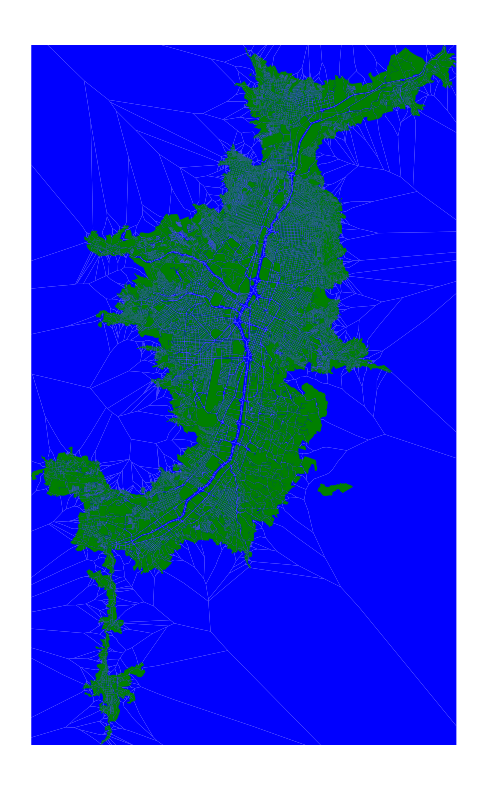

In [6]:
f, ax = plt.subplots(figsize=(10, 10))
blocks.plot(ax=ax, color='g', zorder=1)
tess.plot(ax=ax, color='blue', markersize=5, zorder=0)
ax.set_axis_off()
plt.show()

## Polygons to lines

(18346, 1)


<Axes: >

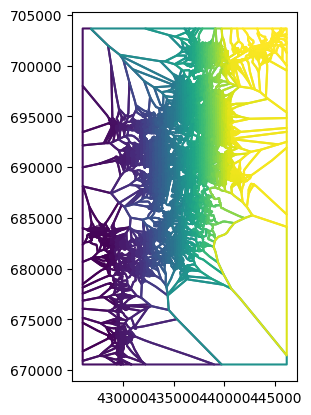

In [7]:
lines_gdf = gpd.GeoDataFrame(geometry=tess.geometry.boundary)
print(lines_gdf.shape)
lines_gdf.reset_index().plot('index')

## Lines to single lines

In [8]:
from shapely import ops

In [9]:
lines_gdf.dissolve().geometry.map(lambda x: ops.linemerge(x))

0    MULTILINESTRING ((427672.535 671396.558, 42668...
Name: geometry, dtype: geometry

In [10]:
lines_single = gpd.GeoDataFrame(geometry=lines_gdf.dissolve().geometry.map(lambda x: ops.linemerge(x)).explode())
lines_single = lines_single.set_crs("EPSG:32613")
lines_single = lines_single.reset_index(drop=True)
lines_single = lines_single.reset_index()
print(lines_single.shape)
lines_single.head(2)

(54956, 2)


,index,geometry
0,0,"LINESTRING (427672.535 671396.558, 426685.093 ..."
1,1,"LINESTRING (426042.967 670909.532, 426042.967 ..."


<Axes: >

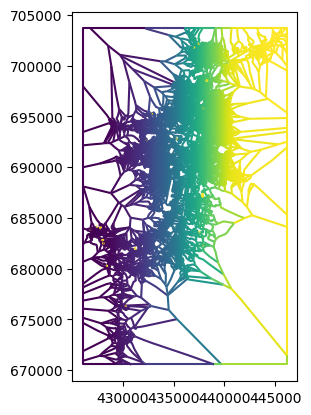

In [11]:
lines_single.plot('index')

## Extract vertices

In [12]:
from shapely.geometry import LineString, Point, Polygon

In [13]:
point_geo = [Point(lines_single.iloc[i].geometry.coords[0]) for i in range(len(lines_single))]

In [14]:
point_geo.extend([Point(lines_single.iloc[i].geometry.coords[-1]) for i in range(len(lines_single))])

In [15]:
len(point_geo)

109912

In [16]:
point_geo_filter = set(point_geo)
len(point_geo_filter)

36645

In [17]:
point_geo_filter = list(point_geo_filter)

Points to GeoDataFrame

In [18]:
import pandas as pd

nodes_gdf = pd.DataFrame(point_geo_filter)
nodes_gdf = nodes_gdf.rename(columns={0:'geometry'})
print(nodes_gdf.shape)
nodes_gdf.head(2)

(36645, 1)


,geometry
0,POINT (432325.3307929142 683222.603078244)
1,POINT (432318.07451052376 690439.2456933168)


<Axes: >

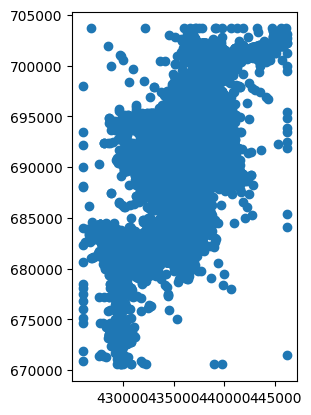

In [19]:
nodes_gdf = nodes_gdf.set_geometry('geometry')
nodes_gdf = nodes_gdf.set_crs("EPSG:32613")
nodes_gdf.plot()

## Create network

In [20]:
nodes, edges = src.network_entities(nodes_gdf, lines_single, crs="EPSG:32613")

In [21]:
print(nodes.shape)
nodes.head(2)

(36645, 3)


,geometry,x,y
osmid,,,
432325.3307929142683222.603078244,POINT (432325.331 683222.603),432325.330793,683222.603078
432318.07451052376690439.2456933168,POINT (432318.075 690439.246),432318.074511,690439.245693


<Axes: >

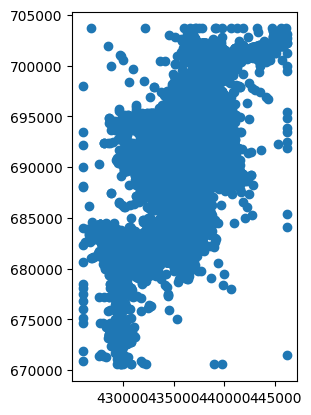

In [22]:
nodes.plot()

In [23]:
print(edges.shape)
edges.head(2)

(54956, 3)


,,,index,geometry,length
u,v,key,,,
427672.53497155494671396.5578676155,426042.96686000004670909.5319337558,0,0,"LINESTRING (427672.535 671396.558, 426685.093 ...",1700.789964
426042.96686000004670909.5319337558,426042.96686000004671851.7784948063,0,1,"LINESTRING (426042.967 670909.532, 426042.967 ...",942.246561


<Axes: >

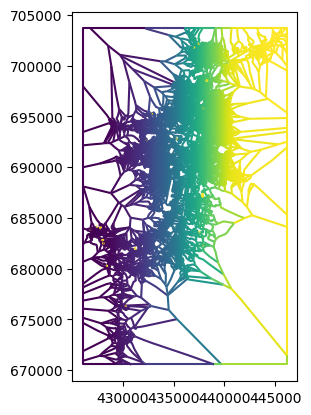

In [24]:
edges.plot('index')

## Consolidate/simplify network

In [25]:
import osmnx as ox

Consolidate

In [26]:
nodes.shape

(36645, 3)

In [27]:
# nodes = nodes.to_crs("EPSG:4326")
# nodes['x'] = nodes.geometry.x
# nodes['y'] = nodes.geometry.y
# edges['length'] = edges.length
# edges = edges.to_crs("EPSG:4326")

In [28]:
print(nodes.shape)
nodes.head(2)

(36645, 3)


,geometry,x,y
osmid,,,
432325.3307929142683222.603078244,POINT (432325.331 683222.603),432325.330793,683222.603078
432318.07451052376690439.2456933168,POINT (432318.075 690439.246),432318.074511,690439.245693


In [29]:
print(edges.shape)
edges.head(2)

(54956, 3)


,,,index,geometry,length
u,v,key,,,
427672.53497155494671396.5578676155,426042.96686000004670909.5319337558,0,0,"LINESTRING (427672.535 671396.558, 426685.093 ...",1700.789964
426042.96686000004670909.5319337558,426042.96686000004671851.7784948063,0,1,"LINESTRING (426042.967 670909.532, 426042.967 ...",942.246561


In [30]:
G = ox.graph_from_gdfs(nodes, edges)

ValueError: `gdf_nodes` and `gdf_edges` must each be uniquely indexed.

In [ ]:
ox.plot_graph(G, node_color="r")

In [ ]:
# G_proj = ox.project_graph(G, to_crs="EPSG:32163")
G2 = ox.consolidate_intersections(G, rebuild_graph=True, tolerance=10, dead_ends=True)

In [ ]:
fig, ax = ox.plot_graph(G2, node_color="r")

In [ ]:
nodes_G2, edges_G2 = ox.graph_to_gdfs(G2)

In [ ]:
edges_G2

In [ ]:
nodes_G2

In [34]:
nodes_G2.to_file('../data/processed/nodes_consolidate_test.geojson')

In [35]:
edges_G2.to_file('../data/processed/edges_consolidate_test.geojson')

Simplify

In [40]:
G3 = ox.simplify_graph(G)
nodes_G3, edges_G3 = ox.graph_to_gdfs(G3)

In [41]:
nodes_G3

,x,y,geometry
osmid,,,
668045.008672288930.8658104907,-103.386521,20.692304,POINT (-103.38652 20.6923)
668045.008672288987.1832702826,-103.386515,20.692812,POINT (-103.38652 20.69281)
668226.50270360462288763.92282,-103.384795,20.690779,POINT (-103.38479 20.69078)
668246.87870886952288894.8493054775,-103.384587,20.691960,POINT (-103.38459 20.69196)
668045.008672289054.0821218835,-103.386509,20.693417,POINT (-103.38651 20.69342)
...,...,...,...
668828.950412289721.5808745036,-103.378920,20.699375,POINT (-103.37892 20.69937)
668828.950412289535.504191729,-103.378938,20.697694,POINT (-103.37894 20.69769)
668828.950412289645.111448182,-103.378928,20.698684,POINT (-103.37893 20.69868)


## Create function

In [9]:
import osmnx as ox
from shapely.geometry import LineString, Point, Polygon
from shapely import ops
import pandas as pd

In [6]:
def network_from_tessellation(gdf, crs):
    # gdf preprocessing
    gdf = gdf.to_crs(crs)
    gdf = gdf.copy()
    gdf = gdf.dissolve().explode().reset_index() # eliminate overlaping polygons and multipolygon
    # create tessellation
    limit = momepy.buffered_limit(gdf, buffer=50)
    tess_gdf = momepy.morphological_tessellation(gdf, clip=limit)
    # polygons to lines
    lines_gdf = gpd.GeoDataFrame(geometry=tess_gdf.geometry.boundary)
    # separate lines by intersection
    lines_single = gpd.GeoDataFrame(geometry=lines_gdf.dissolve().geometry.map(lambda x: ops.linemerge(x)).explode())
    lines_single = lines_single.set_crs(crs)
    lines_single = lines_single.reset_index(drop=True)
    lines_single = lines_single.reset_index()
    # extract first and last vertices from lines
    point_geo = [Point(lines_single.iloc[i].geometry.coords[0]) for i in range(len(lines_single))]
    point_geo.extend([Point(lines_single.iloc[i].geometry.coords[-1]) for i in range(len(lines_single))])
    # remove duplicates
    point_geo_filter = set(point_geo)
    point_geo_filter = list(point_geo_filter)
    # create gdf from point geometries
    nodes_gdf = pd.DataFrame(point_geo_filter)
    nodes_gdf = nodes_gdf.rename(columns={0:'geometry'})
    nodes_gdf = nodes_gdf.set_geometry('geometry')
    nodes_gdf = nodes_gdf.set_crs(crs)
    # create first network and graph
    nodes, edges = src.network_entities(nodes_gdf, lines_single, crs=crs)
    G = ox.graph_from_gdfs(nodes, edges)
    # consolidate graph
    G2 = ox.consolidate_intersections(G, rebuild_graph=True, tolerance=10, dead_ends=True)
    nodes, edges = ox.graph_to_gdfs(G2)

    return nodes, edges


## Comparing speed and output

In [7]:
import time
crs = "EPSG:32618"

In [10]:
start = time.time()
nodes, edges = network_from_tessellation(blocks,crs)
end = time.time()
print(end - start)

ValueError: `gdf_nodes` and `gdf_edges` must each be uniquely indexed.

In [ ]:
print(nodes.shape)
nodes.head(2)

In [ ]:
nodes.plot()

In [ ]:
print(edges.shape)
edges.head(2)

In [ ]:
edges.plot()

### network_from_tessellation_ig_rtree function

In [15]:
if "CVEGEO" in blocks.columns.to_list():
    blocks = blocks.set_index("CVEGEO")

In [16]:
start = time.time()
nodes, edges, tess = src.network_from_tessellation_ig_rtree(blocks)
end = time.time()
print(end - start)

Analyzing touching polygons...

Inward offset...
Generating input point array...


/home/edgaregurrola/Repos/odc/vref_walkability_index/src/analysis.py:169: FutureWarning: Class based API like `momepy.Tessellation` is deprecated. Replace it with `momepy.morphological_tessellation` or `momepy.enclosed_tessellation` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  tessellation_gdf = momepy.Tessellation(new_buildings, unique_id=id_name, limit=limit, shrink=0.1, segment=0.1).tessellation


Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...

Conforming network...

216.66740369796753


In [17]:
print(nodes.shape)
nodes.head(2)

(80, 2)


,osmid,geometry
0,0,POINT (668247.732 2288895.618)
1,3,POINT (668229.248 2288783.233)


<Axes: >

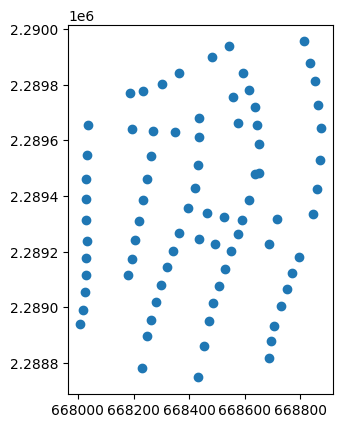

In [18]:
nodes.plot()

In [19]:
print(edges.shape)
edges.head(2)

(134, 4)


,u,v,key,geometry
0,0,3,0,"LINESTRING (668247.732 2288895.618, 668246.897..."
1,0,4,0,"LINESTRING (668247.732 2288895.618, 668246.897..."


<Axes: >

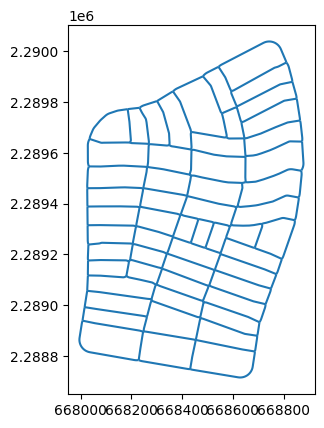

In [20]:
edges.plot()

In [21]:
nodes.to_file('../data/processed/nodes_fn_1.geojson')
edges.to_file('../data/processed/edges_fn_1.geojson')